## Code Attribution

The code presented in this section, which generates dynamic spectra with varying pulse parameters, is the result of my work and has been adapted from Python notebooks authored by Joseph Kania. These notebooks utilized the WILL (Weighted Injector of Luminous Lighthouses) Python package.

### Code Author
- **Dirk Kuiper**

### Sources
The code has been adjusted and customized from the following sources:

- Joseph Kania's Python example notebooks, which provided the foundational code for generating dynamic spectra with pulses. These notebooks served as a valuable reference and inspiration for the implementation of the following code.

- The WILL (Weighted Injector of Luminous Lighthouses) Python package, which was used for several functions and utilities, enhancing the capabilities of the code.


## Show how we can inject a pulse into a GREENBURST filterbank.

In [2]:
import tempfile
from urllib import request

import matplotlib.pyplot as plt
import numpy as np
from jess.dispersion import dedisperse
from jess.fitters import median_fitter
from scipy.stats import median_abs_deviation
from will import create, inject, detect
from your import Your
from simulate_frbs import create_filterbank_with_noise, inject_pulse_into_dynamic_spectrum

In [3]:
def show_dynamic(
    dynamic_spectra: np.ndarray, title: str = None, save: bool = False
) -> None:
    """
    Show a dynamic spectra by first flattening it
    in frequency. Do this by getting the medians of
    each channel and then run a median filter along the
    bandpass.

    Then set the limits of the imshow so we get good detail
    for the majority of the data.

    Args:
        dynmaic_spectra - the dynamic spectra to plot

        title - Title of plot

        save - Save the plot as `title` + `.png`
    """
    spectra_mads = median_fitter(np.median(dynamic_spectra, axis=0))
    flat = dynamic_spectra - spectra_mads
    std = median_abs_deviation(flat, axis=None)
    med = np.median(flat)
    plt.figure(figsize=(20, 10))
    plt.imshow(flat.T, vmin=med - 3 * std, vmax=med + 6 * std, aspect="auto")
    plt.xlabel("Time Sample #", size=20)
    plt.ylabel("Channel #", size=20)
    plt.colorbar()
    plt.tight_layout()
    if title is not None:
        plt.title(title, size=28)
    if save:
        plt.savefig(title.replace(" ", "_") + ".png", dpi=75, bbox_inches="tight")

## Get a pulse search mode file

This was created in the example file and is very interesting as you can also study what the effects of RFI etc are on what we want to do, but for now it's unnecessarily complicated, it is convenient to create a spectrum though, i will just fill it with Gaussian noise for now

In [4]:
# Get a 33MB filbterbank from zenodo, put it in
# a temp directory
temp_dir = tempfile.TemporaryDirectory()
empty_fil = temp_dir.name + "/empty_example.fil"
request.urlretrieve(
    "https://zenodo.org/record/5860557/files/empty_example.fil", empty_fil
)

('/var/folders/xf/v65w5l3x0859xrc4gk4jyjvm0000gn/T/tmpoog1_5e5/empty_example.fil',
 <http.client.HTTPMessage at 0x7fa62e649640>)

## Find out what the header looks like of the Greenbank file

In [5]:
yr_obj = Your(empty_fil)
yr_obj.your_header

Unified Header:
  "basename": "empty_example"
  "bw": -960.0
  "center_freq": 1440.0
  "dec_deg": 11.375955555555556
  "dtype": "uint8"
  "fch1": 1919.8828125
  "filelist": [
    "/var/folders/xf/v65w5l3x0859xrc4gk4jyjvm0000gn/T/tmpoog1_5e5/empty_example.fil"
  ]
  "filename": "/var/folders/xf/v65w5l3x0859xrc4gk4jyjvm0000gn/T/tmpoog1_5e5/empty_example.fil"
  "foff": -0.234375
  "format": "fil"
  "frequency_decimation_factor": 1
  "gb": 63.85089912218148
  "gl": 65.66179798134573
  "native_foff": -0.234375
  "native_nbits": 8
  "native_nchans": 4096
  "native_nspectra": 8192.0
  "native_tsamp": 0.000256
  "nbits": 8
  "nchans": 4096
  "npol": 1
  "nspectra": 8192
  "poln_order": "I"
  "ra_deg": 170.63933333333335
  "source_name": "TEMP"
  "time_decimation_factor": 1
  "tsamp": 0.000256
  "tstart": 59319.97462321287
  "tstart_utc": "2021-04-15T23:23:27.446"

## Creating a fresh filterbank file from scratch

Code adapted from: https://thepetabyteproject.github.io/your/0.6.6/ipynb/Writer/

I tried to make the header as consistent as possible with the Greenbank data from Zenodo, in case we will want to use it later to test with RFI etc.

In [6]:
# Create a filterbank with noise, std is such that the lightcurve will have std 1
create_filterbank_with_noise("output_with_noise__2.fil", std_value=np.sqrt(1.0/4096), mean_value=0.0)


[[-0.00690972 -0.01394704 -0.02732752 ...  0.0263065  -0.00132549
  -0.0334107 ]
 [ 0.02550475  0.01316996  0.00635767 ... -0.00623923 -0.00225831
  -0.01015233]
 [ 0.00401767  0.00406297 -0.02164929 ... -0.00699984  0.00807071
   0.00890176]
 ...
 [ 0.00318703  0.00507708  0.00731491 ...  0.00342621  0.00666044
   0.00453697]
 [-0.00325574  0.00864379 -0.0078309  ... -0.00135426  0.00944848
  -0.00111115]
 [-0.01545491  0.03161401  0.00837663 ...  0.02645002 -0.01193289
  -0.00073108]]
4096
2.8852778e-06
0.015624207


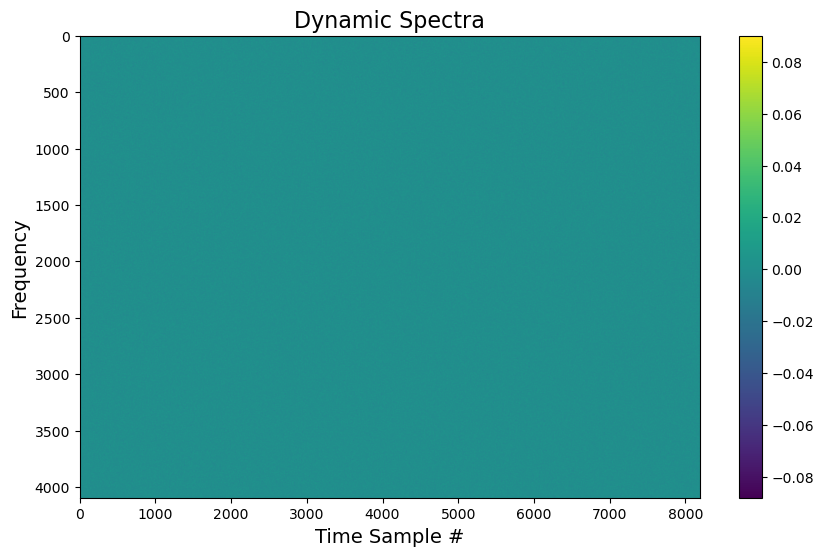

1.0096143


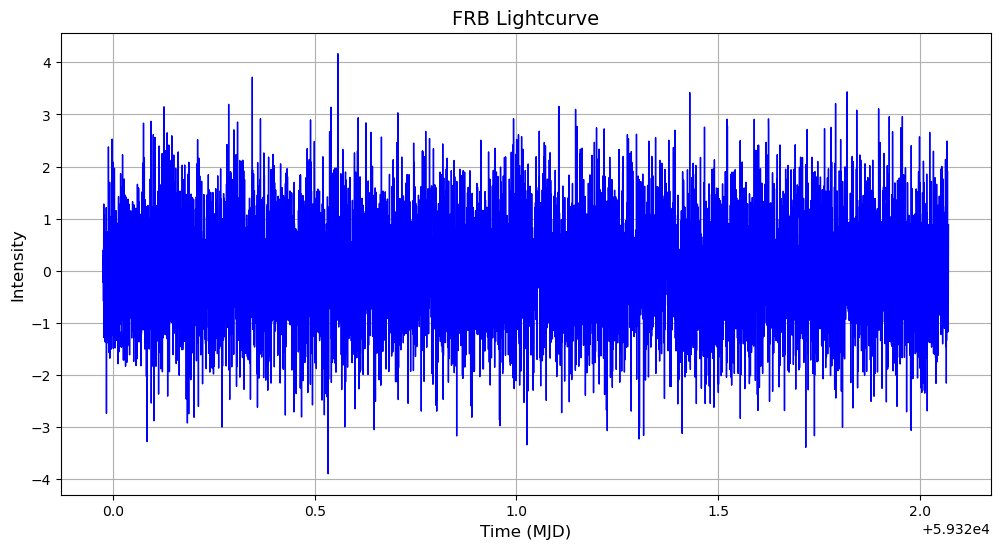

In [7]:
temp_dir = tempfile.TemporaryDirectory()
yr_obj = Your("output_with_noise__2.fil")
dynamic_spectra = yr_obj.get_data(0, 8192)

print(dynamic_spectra)

num_frequency_channels = yr_obj.your_header.nchans

print(num_frequency_channels)

print(np.mean(dynamic_spectra))
print(np.std(dynamic_spectra))


# Plot the dynamic spectra with swapped axes and reversed y-axis
plt.figure(figsize=(10, 6))
plt.imshow(dynamic_spectra.T, aspect="auto", cmap="viridis")
plt.xlabel("Time Sample #", size=14)
plt.ylabel("Frequency", size=14)
plt.colorbar()
plt.title(f"Dynamic Spectra", size=16)
plt.show()

lightcurve = np.sum(dynamic_spectra, axis=1)

print(np.std(lightcurve))

# Extract header information
tsamp = 0.000256
tstart = 59319.97462321287

# Create a time axis for the lightcurve
num_time_samples = len(lightcurve)
time_axis = np.arange(num_time_samples) * tsamp + tstart

# Plot the lightcurve
plt.figure(figsize=(12, 6))
plt.plot(time_axis, lightcurve, color='blue', lw=1)
plt.xlabel("Time (MJD)", fontsize=12)
plt.ylabel("Intensity", fontsize=12)
plt.title("FRB Lightcurve", fontsize=14)
plt.grid(True)
plt.show()

## Create a simple Pulse

(5227, 4096)


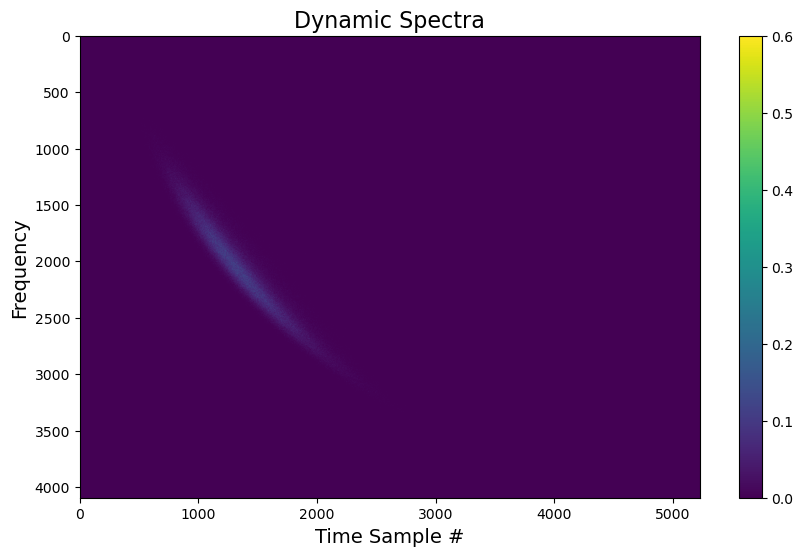

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Maximum value in the pulse: 0.6000000238418579


In [8]:
dm = 300
# create the pulse object
pulse_obj = create.SimpleGaussPulse(
    sigma_time=0.015,
    sigma_freq=100,
    center_freq=yr_obj.your_header.center_freq,
    dm=dm,
    tau=100,
    phi=np.pi / 3,
    spectral_index_alpha=0,
    chan_freqs=yr_obj.chan_freqs,
    tsamp=yr_obj.your_header.tsamp,
    nscint=0,
    bandpass=None,
)


# pulse with 3e5 samples
pulse = pulse_obj.sample_pulse(nsamp=int(3e5), dtype=np.float32)

print(np.shape(pulse))

pulse = (pulse * 0.075).astype(np.float32)

# Plot the dynamic spectra with swapped axes and reversed y-axis
plt.figure(figsize=(10, 6))
plt.imshow(pulse.T, aspect="auto", cmap="viridis")
plt.xlabel("Time Sample #", size=14)
plt.ylabel("Frequency", size=14)
plt.colorbar()
plt.title(f"Dynamic Spectra", size=16)
plt.show()

print(pulse)
max_value = np.max(pulse)

print(f"Maximum value in the pulse: {max_value}")

# # Define the range
# min_value = 5
# max_value = 80

# # Define the exponent for the power law distribution
# exponent = -1.5  # Use a negative exponent

# # Generate a random number from a power law-like distribution
# scaling_factor = ((max_value**(exponent+1) - min_value**(exponent+1)) * np.random.random(1) + min_value**(exponent+1))**(1/(exponent+1))

# print(scaling_factor)

# pulse = (pulse * scaling_factor).astype(np.float32)

# print(pulse)



## Inject the Pulse

In [9]:
# Inject the pulse into the dynamic spectrum
dynamic_spectra_with_pulse = inject_pulse_into_dynamic_spectrum(dynamic_spectra, pulse)

## Show injected Pulse

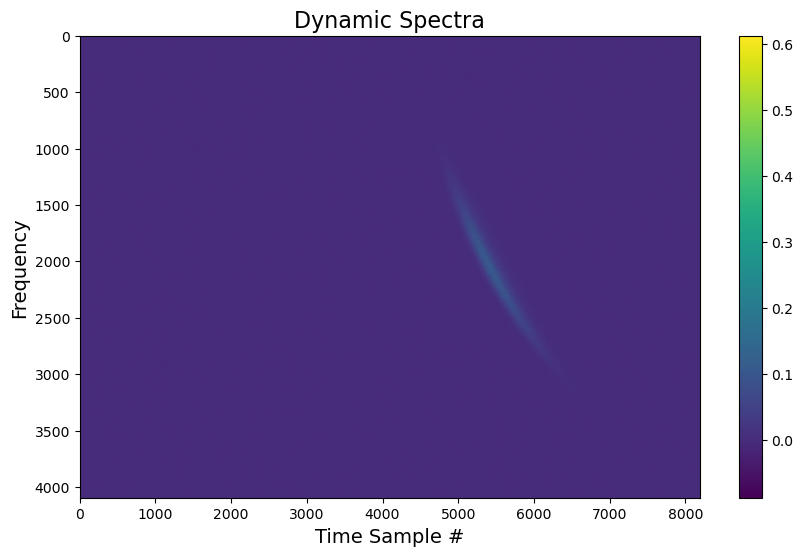

In [10]:
# show_dynamic(dynamic_spectra_copy, title=f"Dynamic Spectra + {dm} dm Pulse")

# Plot the dynamic spectra with swapped axes and reversed y-axis
plt.figure(figsize=(10, 6))
plt.imshow(dynamic_spectra_with_pulse.T, aspect="auto", cmap="viridis")
plt.xlabel("Time Sample #", size=14)
plt.ylabel("Frequency", size=14)
plt.colorbar()
plt.title(f"Dynamic Spectra", size=16)
plt.show()

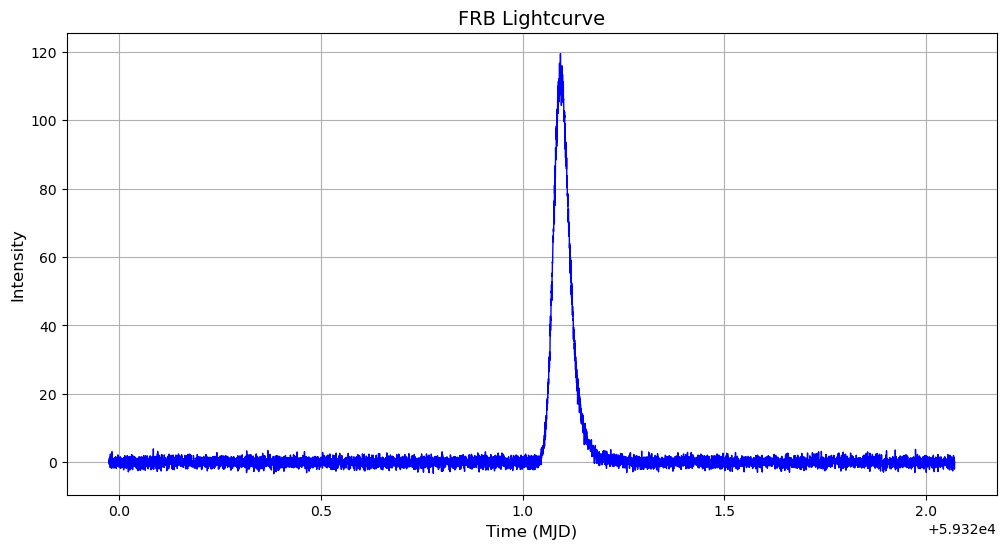

RMS of the noise: 1.0076955556869507
119.45663
118.576355
118.544365


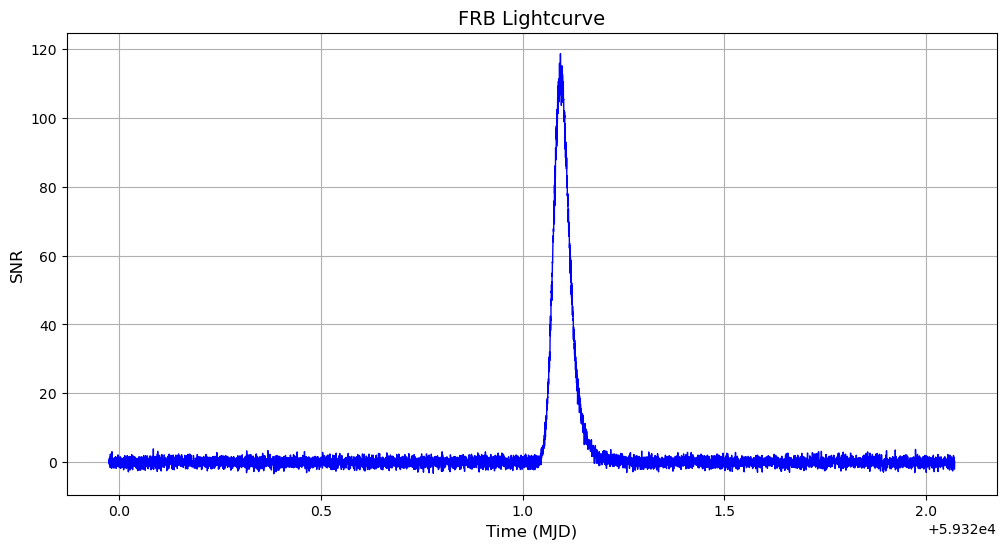

In [27]:
# Sum the frequencies along the frequency axis to get a 1D time series (lightcurve)
lightcurve = np.sum(dedisperse(
        dynamic_spectra_copy,
        dm=dm,
        chan_freqs=yr_obj.chan_freqs,
        tsamp=yr_obj.your_header.tsamp,
    ), axis=1)

# Extract header information
tsamp = 0.000256
tstart = 59319.97462321287

# Create a time axis for the lightcurve
num_time_samples = len(lightcurve)
time_axis = np.arange(num_time_samples) * tsamp + tstart

# Plot the lightcurve
plt.figure(figsize=(12, 6))
plt.plot(time_axis, lightcurve, color='blue', lw=1)
plt.xlabel("Time (MJD)", fontsize=12)
plt.ylabel("Intensity", fontsize=12)
plt.title("FRB Lightcurve", fontsize=14)
plt.grid(True)
plt.show()

squared_values = lightcurve[0:1000] ** 2

# Calculate the mean of the squared values
mean_squared = np.mean(squared_values)

# Take the square root to get the RMS
rms = np.sqrt(mean_squared)

print(f"RMS of the noise: {rms}")

print(np.max(lightcurve))

print(np.max(lightcurve) / np.std(lightcurve[0:1000]))

print(np.max(lightcurve)/rms)

# Plot the lightcurve
plt.figure(figsize=(12, 6))
plt.plot(time_axis, lightcurve/np.std(lightcurve[0:1000]), color='blue', lw=1)
plt.xlabel("Time (MJD)", fontsize=12)
plt.ylabel("SNR", fontsize=12)
plt.title("FRB Lightcurve", fontsize=14)
plt.grid(True)
plt.show()


## Now for a pulse with complex time-frequency structure

In [28]:
dm_1 = 155
pulse_obj_complex = create.GaussPulse(
    relative_intensities=(0.8, 0.6, 1, 0.8),
    sigma_times=(0.005, 0.001, 0.001, 0.006),
    sigma_freqs=(150, 120, 120, 90),
    pulse_thetas=(0, 0, 0, -np.pi / 60),
    center_freqs=(1500, 1400, 1350, 1200),
    dm=dm_1,
    tau=25,
    offsets=(0, 0.01536, 0.02304, 0.03968),  # all from start of window
    chan_freqs=yr_obj.chan_freqs,
    tsamp=0.000256,
    spectral_index_alpha=0,
    nscint=2,
    phi=0,
    bandpass=None,
)
# pulse with 3e5 samples
pulse_complex = pulse_obj_complex.sample_pulse(nsamp=int(3e5))

max_value = np.max(pulse_complex)

print(f"Maximum value in the pulse: {max_value}")



Maximum value in the pulse: 10


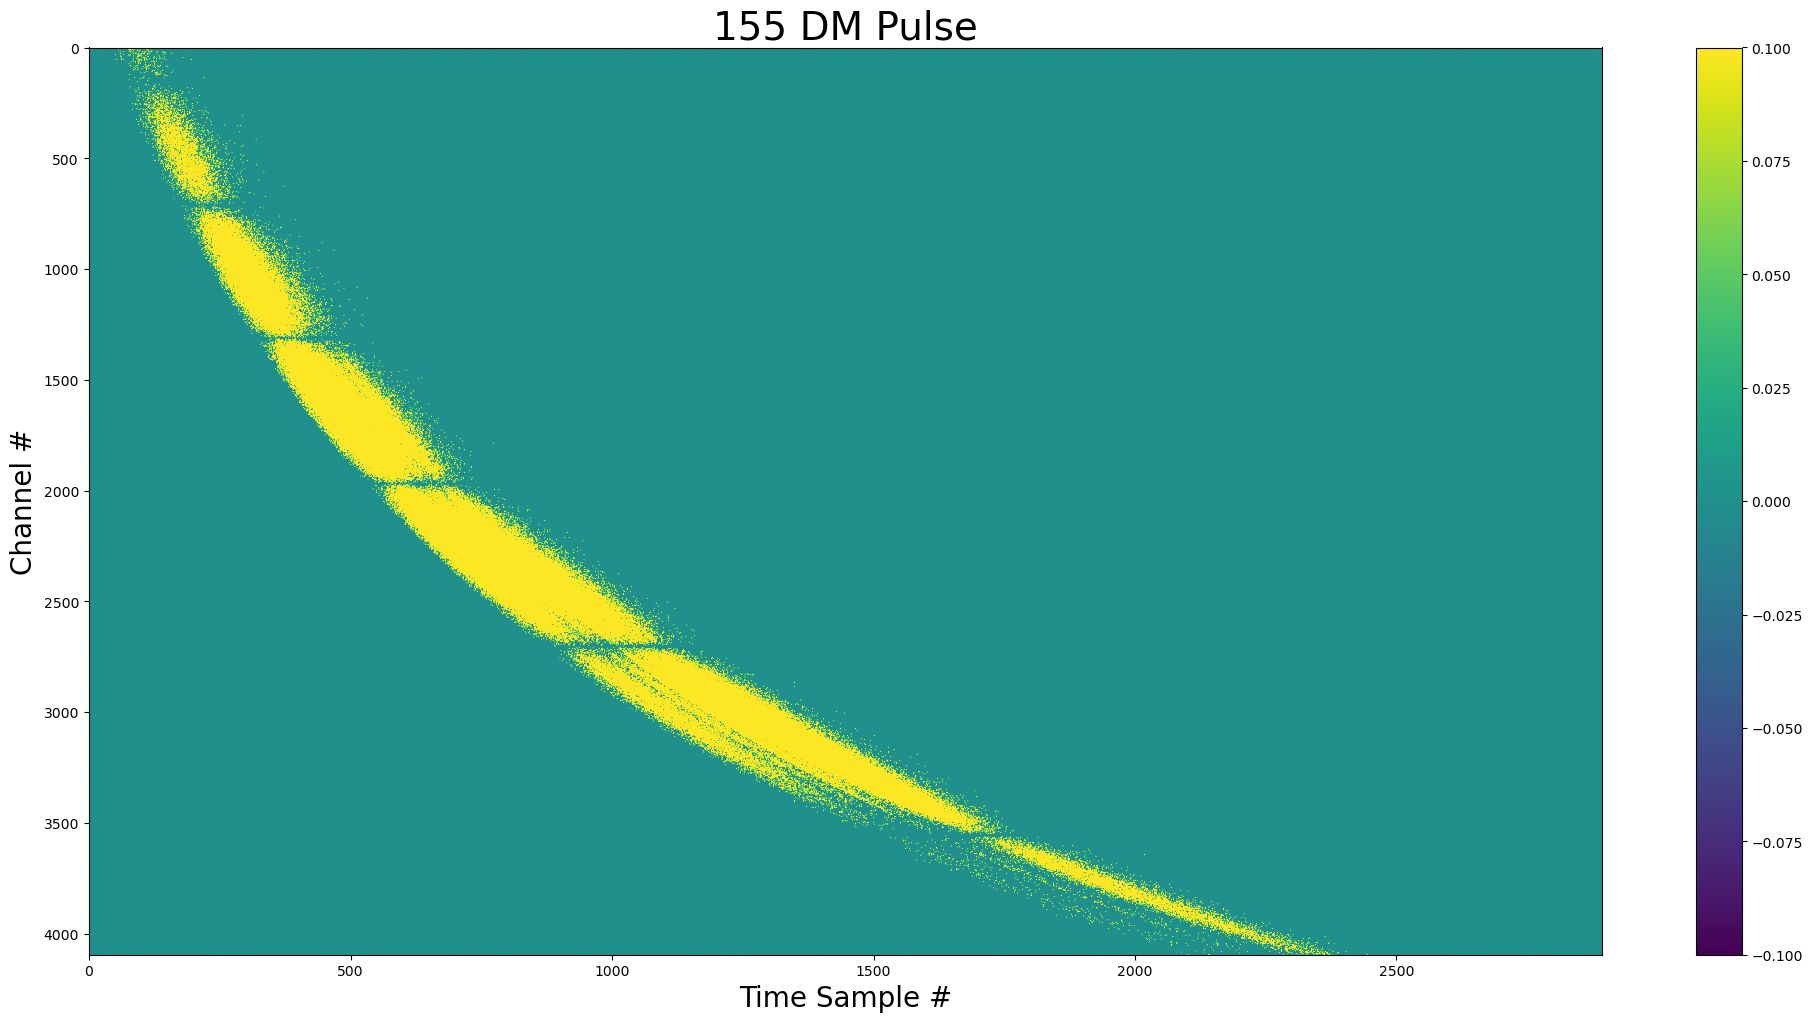

In [29]:
show_dynamic(pulse_complex, title=f"{dm_1} DM Pulse")

## Inject the pulse

In [30]:
dynamic_spectra_w_pulse_complex = inject.inject_constant_into_file(
    yr_input=yr_obj,
    pulse=pulse_complex,
    start=yr_obj.your_header.nspectra // 2 ,
    gulp=yr_obj.your_header.nspectra,
)

ValueError: Invalid integer data type 'f'.

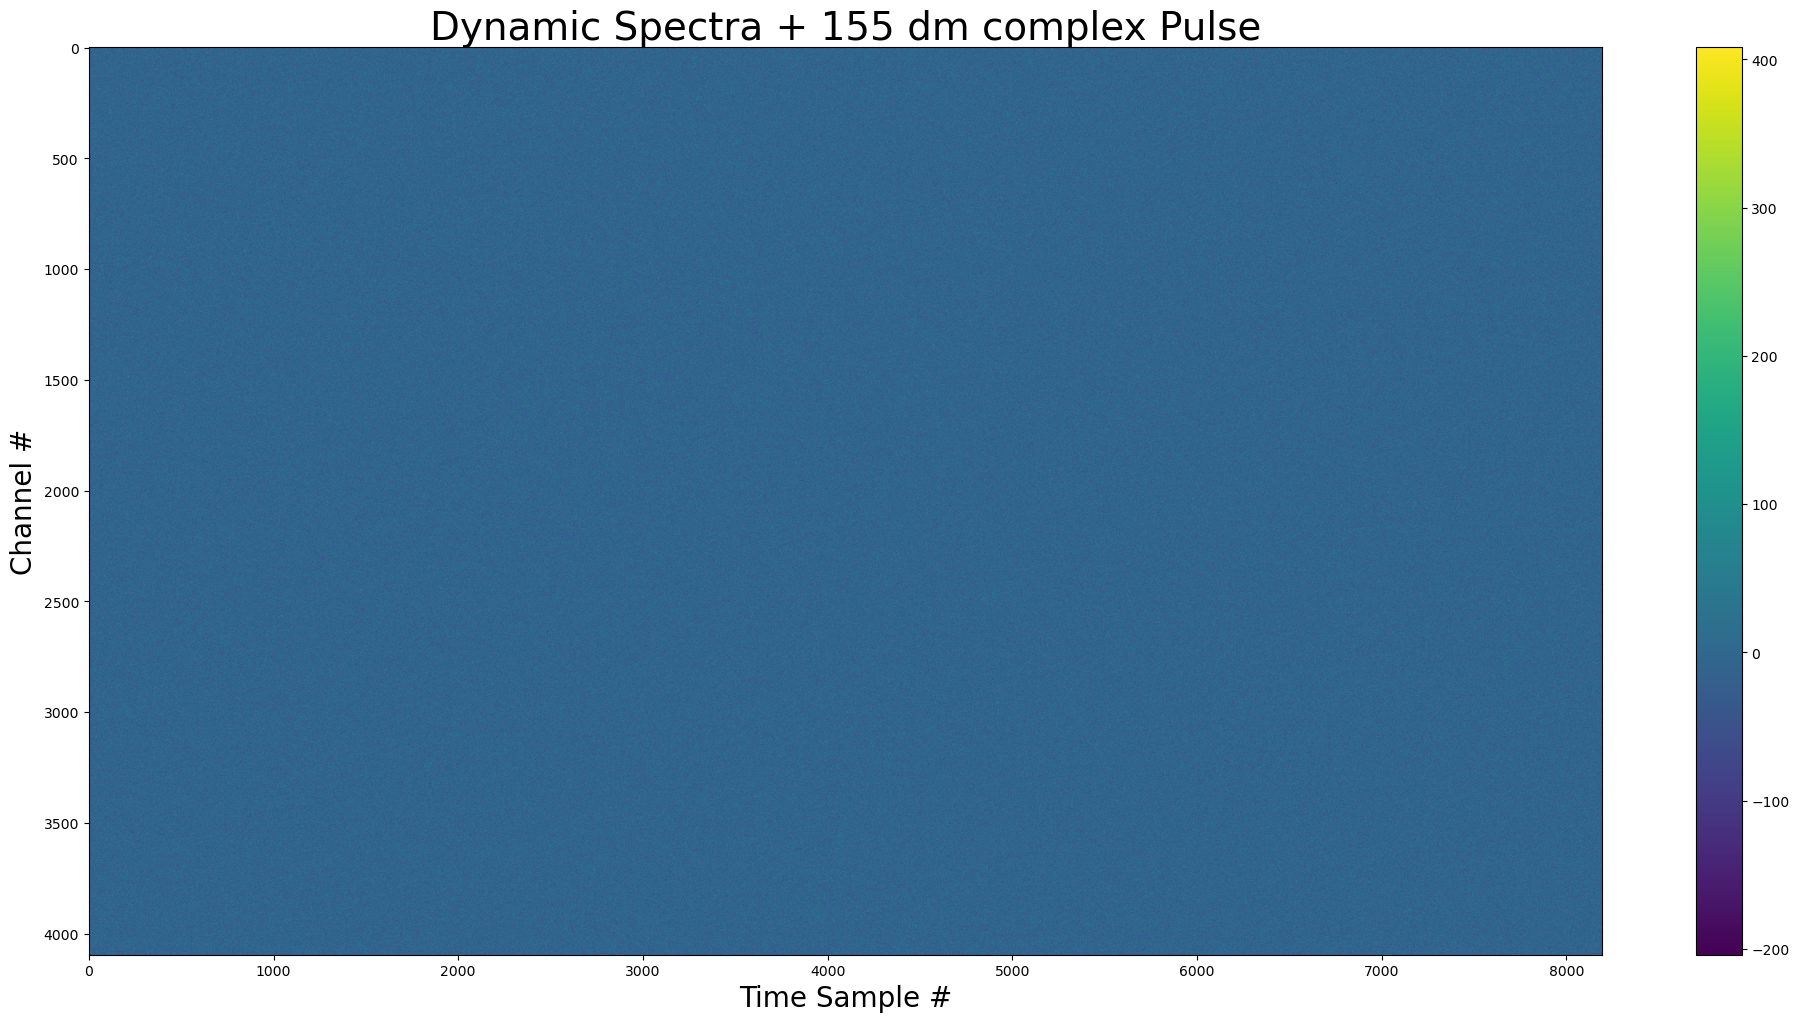

In [ ]:
show_dynamic(dynamic_spectra_w_pulse_complex, title=f"Dynamic Spectra + {dm_1} dm complex Pulse")

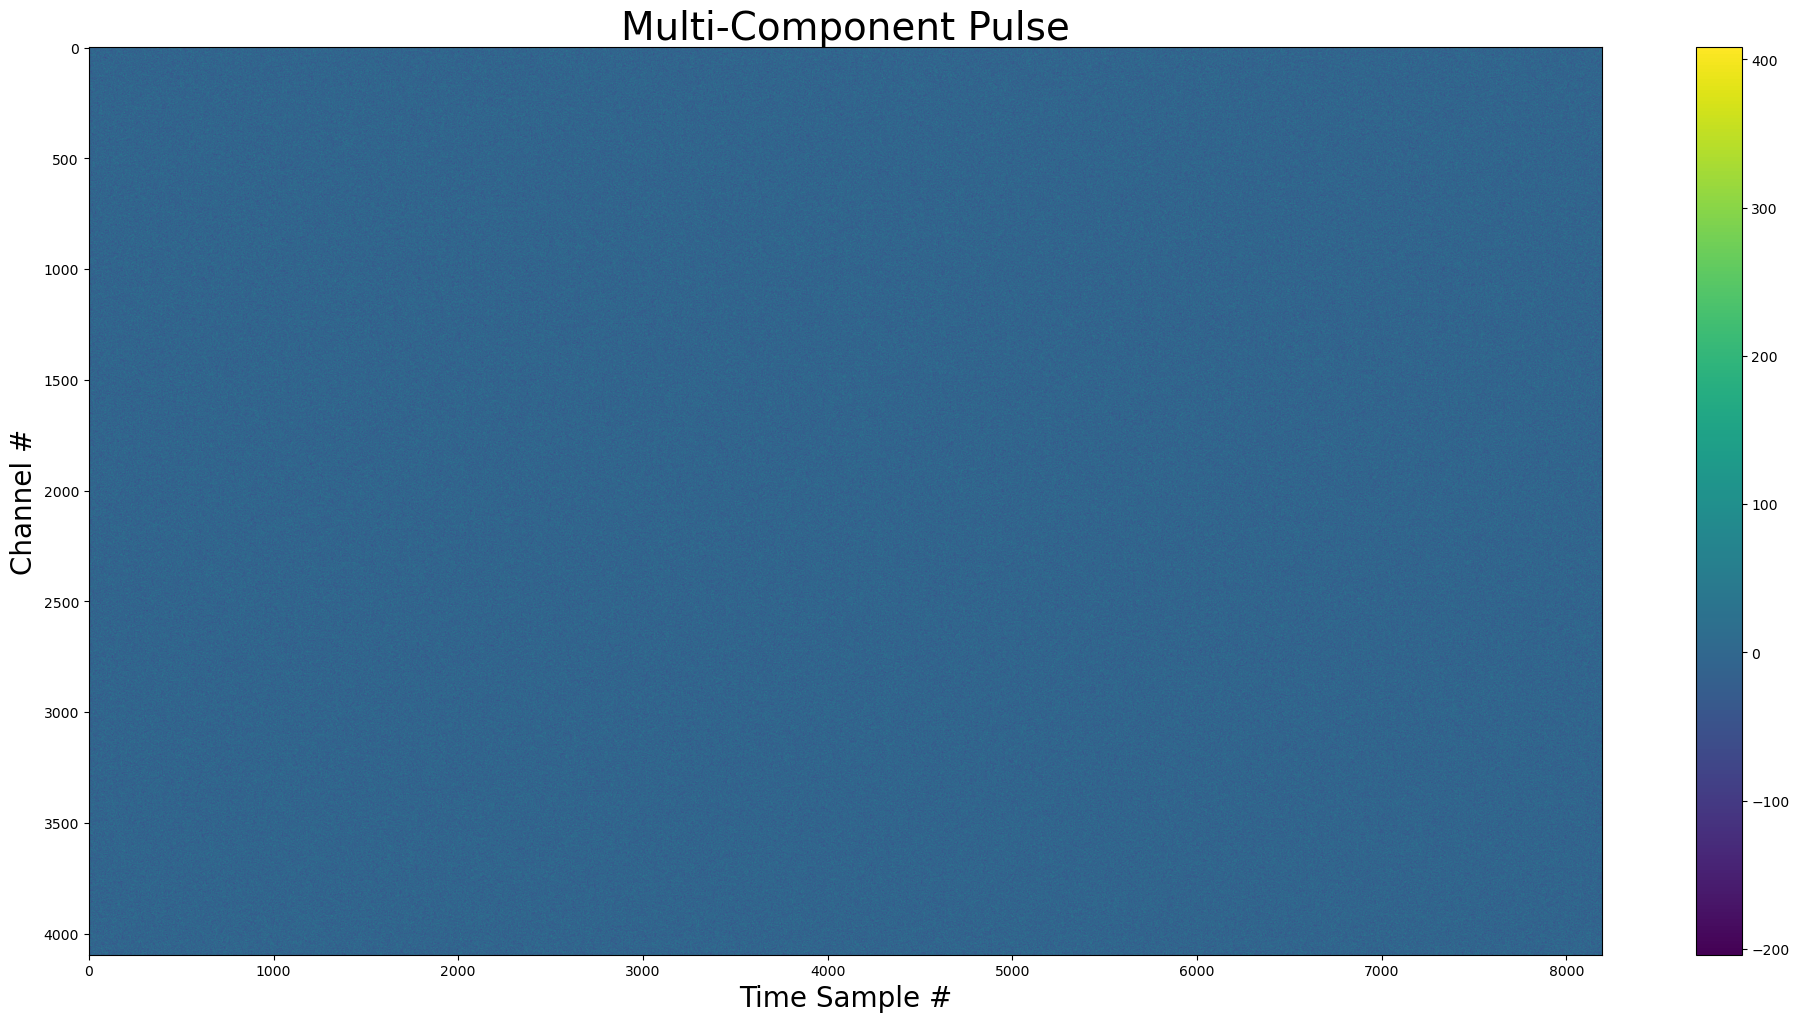

In [ ]:
show_dynamic(
    dedisperse(
        dynamic_spectra_w_pulse_complex,
        dm=dm_1,
        chan_freqs=yr_obj.chan_freqs,
        tsamp=yr_obj.your_header.tsamp,
    ),
    title="Multi-Component Pulse",
    save=True,
)

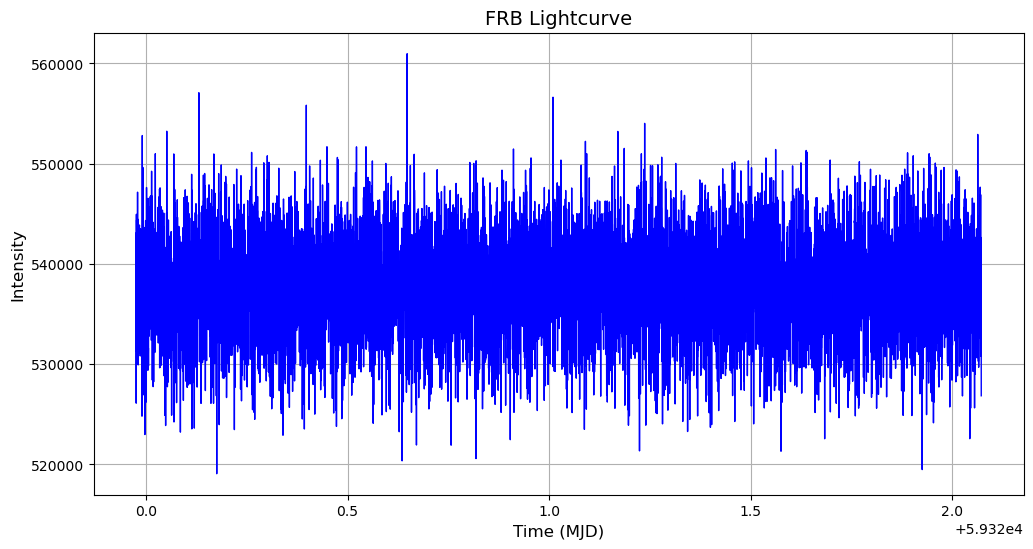

In [ ]:
dedispersed_complex_pulse = dedisperse(
        dynamic_spectra_w_pulse_complex,
        dm=dm,
        chan_freqs=yr_obj.chan_freqs,
        tsamp=yr_obj.your_header.tsamp,
    )


# Sum the frequencies along the frequency axis to get a 1D time series (lightcurve)
lightcurve = np.sum(dedispersed_complex_pulse, axis=1)

# Extract header information
tsamp = 0.000256
tstart = 59319.97462321287

# Create a time axis for the lightcurve
num_time_samples = len(lightcurve)
time_axis = np.arange(num_time_samples) * tsamp + tstart

# Plot the lightcurve
plt.figure(figsize=(12, 6))
plt.plot(time_axis, lightcurve, color='blue', lw=1)
plt.xlabel("Time (MJD)", fontsize=12)
plt.ylabel("Intensity", fontsize=12)
plt.title("FRB Lightcurve", fontsize=14)
plt.grid(True)
plt.show()

## Generate simple frbs

Injecting Pulses ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

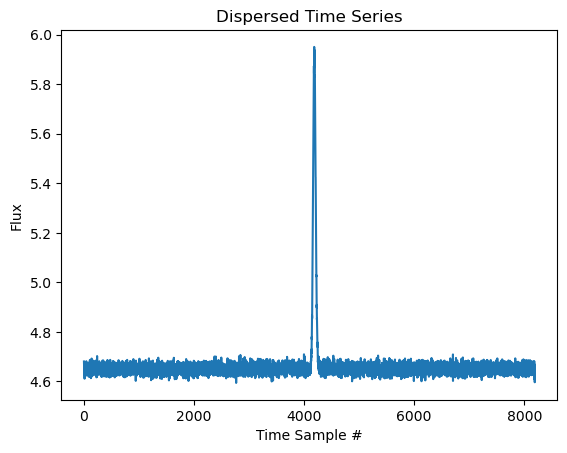

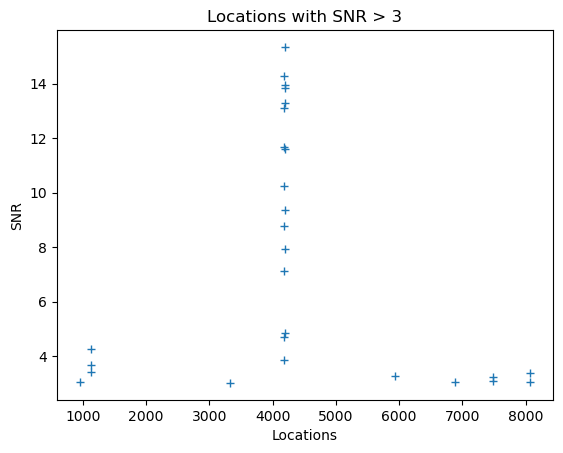

[array([8.093877]), array([20.90310577]), array([11.42379036]), array([19.53589682]), array([8.32874397]), array([24.52469038]), array([10.00189305]), array([10.34825265]), array([21.8935727]), array([48.56326201]), array([4.24746248]), array([48.87039574]), array([98.85490401]), array([44.06465627]), array([31.00222257]), array([22.84758073]), array([17.19645039]), array([25.33893926]), array([8.16071833]), array([54.68786984]), array([11.53316708]), array([28.38325787]), array([144.73827372]), array([4.24746248]), array([187.9598178]), array([61.42674511]), array([38.65859271]), array([21.18870053]), array([21.85467235]), array([25.825058]), array([21.23123592]), array([4.24746248]), array([11.0227424]), array([76.86172037]), array([59.19249781]), array([49.13445153]), array([12.26842167]), array([17.38015553]), array([35.29026729]), array([4.24746248]), array([30.95426175]), array([37.1577011]), array([82.24559391]), array([21.86926677]), array([38.74702726]), array([29.25219511]), 

ValueError: The 'color' keyword argument must have one color per dataset, but 100 datasets and 1 colors were provided

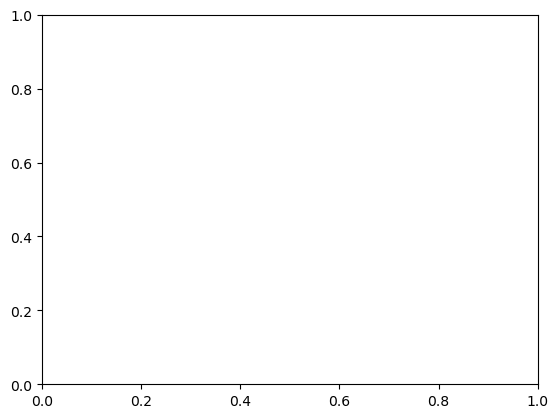

In [ ]:
import os

# Directory to save the numpy arrays
save_dir = "simulated_simple_frbs"

# Create the directory if it doesn't exist
os.makedirs(save_dir, exist_ok=True)

snrs = []

# Set the constant DM value
dm = 200

# Define the mean values for the Gaussian distributions
mean_value_for_sigma_time = 0.005  # Mean value for pulse width
mean_value_for_sigma_freq = 350    # Mean value for frequency width

# Standard deviations for the Gaussian distributions (adjust as needed)
std_deviation_for_sigma_time = 0.001
std_deviation_for_sigma_freq = 50

# Generate 10 different dynamic spectra with varying signal and temporal widths
num_pulses = 100

for i in range(num_pulses):
    # Draw random values for signal width and temporal width from Gaussian distributions
    sigma_time = np.random.normal(mean_value_for_sigma_time, std_deviation_for_sigma_time)
    sigma_freq = np.random.normal(mean_value_for_sigma_freq, std_deviation_for_sigma_freq)
    
    # Create the pulse object with the specified parameters
    pulse_obj = create.SimpleGaussPulse(
        sigma_time=sigma_time,
        sigma_freq=sigma_freq,
        center_freq=yr_obj.your_header.center_freq,
        dm=dm,  
        tau=20,
        phi=np.pi / 3,
        spectral_index_alpha=0,
        chan_freqs=yr_obj.chan_freqs,
        tsamp=yr_obj.your_header.tsamp,
        nscint=0,
        bandpass=None,
    )
    
    # Scale the SNR of the pulse according to powerlaw with slope -1.5 so more weak pulses
    min_value = .75
    max_value = 5

    # Define the exponent for the power law distribution
    exponent = -1.5  # Use a negative exponent

    # Generate a random number from a power law-like distribution
    scaling_factor = ((max_value**(exponent+1) - min_value**(exponent+1)) * np.random.random(1) + min_value**(exponent+1))**(1/(exponent+1))

    # Generate the pulse signal with the specified parameters
    pulse = pulse_obj.sample_pulse(nsamp=int(3e5))

    pulse = pulse * int(scaling_factor)
    
    # Inject the pulse into the dynamic spectra
    dynamic_spectra_w_pulse = inject.inject_constant_into_file(
        yr_input=yr_obj,
        pulse=pulse,
        start=yr_obj.your_header.nspectra // 2,
        gulp=yr_obj.your_header.nspectra,
    )

    dynamic_spectra_w_pulse_dedisp = dedisperse(
        dynamic_spectra_w_pulse,
        dm=dm,
        chan_freqs=yr_obj.chan_freqs,
        tsamp=yr_obj.your_header.tsamp,
    )

    time_series = detect.dedisped_time_series(
        dynamic_spectra_w_pulse,
        dm=dm,
        chan_freqs=yr_obj.chan_freqs,
        tsamp=yr_obj.your_header.tsamp,
    )

    plt.title("Dispersed Time Series")
    plt.xlabel("Time Sample #")
    plt.ylabel("Flux")
    plt.plot(time_series)
    plt.show()

    sigma = 3
    pulses = detect.detect_all_pulses(time_series, box_car_length=8, sigma=sigma)
    snrs.append(max(pulses.snrs))

    plt.title(f"Locations with SNR > {sigma}")
    plt.plot(pulses.locations, pulses.snrs, "+")
    plt.ylabel("SNR")
    plt.xlabel("Locations")
    plt.show()
    
    # Define a filename for the numpy array
    filename = os.path.join(save_dir, f"frb_{i}_{sigma_time}_{sigma_freq}.npy")
    
    # Save the dynamic spectra as a numpy array
    np.save(filename, dynamic_spectra_w_pulse_dedisp)

print(snrs)
# After generating SNRs for all pulses, plot the histogram
plt.hist(snrs, bins=20, density=True, alpha=0.7, color='b')
plt.xlabel("SNR")
plt.ylabel("Frequency")
plt.title("SNR Histogram")
plt.show()


## Generate complex frbs

In [ ]:
import os
import numpy as np

# Directory to save the numpy arrays for complex pulses
save_dir_complex = "simulated_complex_frbs"

# Create the directory if it doesn't exist
os.makedirs(save_dir_complex, exist_ok=True)

# Set the constant DM value
dm = 200

# Define the mean values for the Gaussian distributions
mean_value_for_sigma_time = 0.005  # Mean value for pulse width
mean_value_for_sigma_freq = 350    # Mean value for frequency width

# Standard deviations for the Gaussian distributions (adjust as needed)
std_deviation_for_sigma_time = 0.001
std_deviation_for_sigma_freq = 50

# Generate 10 different dynamic spectra with varying signal and temporal widths for complex pulses
num_pulses = 100

for i in range(num_pulses):
    # Draw random values for signal width and temporal width from Gaussian distributions
    sigma_time = np.random.normal(mean_value_for_sigma_time, std_deviation_for_sigma_time)
    sigma_freq = np.random.normal(mean_value_for_sigma_freq, std_deviation_for_sigma_freq)
    
    # Create the pulse object with the specified parameters for complex pulses
    pulse_obj_complex = create.GaussPulse(
        relative_intensities=(1, 0.8, 0.8, 0.8),
        sigma_times=(sigma_time, sigma_time * 0.2, sigma_time * 0.2, sigma_time * 1.2),
        sigma_freqs=(sigma_freq, sigma_freq * 0.8, sigma_freq * 0.8, sigma_freq * 0.6),
        pulse_thetas=(0, 0, 0, -np.pi / 60),
        center_freqs=(yr_obj.your_header.center_freq, yr_obj.your_header.center_freq - 100, yr_obj.your_header.center_freq - 200, yr_obj.your_header.center_freq - 400),
        dm=dm,
        tau=25,
        offsets=(0, 0.01536, 0.02304, 0.03968),  # all from start of window
        chan_freqs=yr_obj.chan_freqs,
        tsamp=yr_obj.your_header.tsamp,
        spectral_index_alpha=0,
        nscint=2,
        phi=0,
        bandpass=None,
    )

    # Scale the SNR of the pulse according to powerlaw with slope -1.5 so more weak pulses
    min_value = .75
    max_value = 5

    # Define the exponent for the power law distribution
    exponent = -1.5  # Use a negative exponent

    # Generate a random number from a power law-like distribution
    scaling_factor = ((max_value**(exponent+1) - min_value**(exponent+1)) * np.random.random(1) + min_value**(exponent+1))**(1/(exponent+1))

    # Generate the complex pulse signal with the specified parameters
    pulse_complex = pulse_obj_complex.sample_pulse(nsamp=int(3e5))

    pulse_complex = pulse_complex * int(scaling_factor)
    
    
    
    # Inject the complex pulse into the dynamic spectra
    dynamic_spectra_w_pulse_complex = inject.inject_constant_into_file(
        yr_input=yr_obj,
        pulse=pulse_complex,
        start=yr_obj.your_header.nspectra // 2,
        gulp=yr_obj.your_header.nspectra,
    )

    dynamic_spectra_w_pulse_complex_dedisp = dedisperse(
        dynamic_spectra_w_pulse_complex,
        dm=dm,
        chan_freqs=yr_obj.chan_freqs,
        tsamp=yr_obj.your_header.tsamp,
    )
    
    # Define a filename for the numpy array for complex pulses
    filename_complex = os.path.join(save_dir_complex, f"complex_frb_{i}_{sigma_time}_{sigma_freq}.npy")
    
    # Save the dynamic spectra with complex pulses as a numpy array
    np.save(filename_complex, dynamic_spectra_w_pulse_complex_dedisp)


Injecting Pulses ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--